# Анализ результатов A/B-теста для последующего принятия решений в бизнесе

Описание проекта

Я — аналитик крупного интернет-магазина. Вместе с отделом маркетинга мы подготовили список гипотез для увеличения выручки.
Приоритизируем гипотезы, запустим A/B-тест и проанализируем результаты.

Описание данных

Файл_1
- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Файл_2
- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

Файл_3
- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста

### Приоритизация гипотез.
В файле_1 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort.

#### Предоброботка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import warnings

import seaborn as sns
sns.set(rc={'figure.figsize':(10, 8)})

from scipy import stats as st

import math
import numpy as np

In [2]:
pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 150 
pd.options.display.float_format = '{:,.2f}'.format

In [3]:
hypothesis = pd.read_csv('/file.csv')
orders = pd.read_csv('/file2.csv')
visitors = pd.read_csv('/file3.csv')

In [4]:
def predobr (df):
    df.info()
    display(df.head())
    print(df.isna().sum())
    print(df.duplicated().sum())
            
predobr(hypothesis)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


Hypothesis    0
Reach         0
Impact        0
Confidence    0
Efforts       0
dtype: int64
0


In [5]:
predobr(orders)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64
0


In [6]:
predobr(visitors)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


date        0
group       0
visitors    0
dtype: int64
0


In [7]:
# там, где в таблицах даты, нужно поправить тип
orders['date'] = pd.to_datetime(orders['date'])
visitors['date'] = pd.to_datetime(visitors['date'])

# поменяем регистр в названии колонок
hypothesis.columns = [x.lower() for x in hypothesis.columns.values]
orders.columns = [x.lower() for x in orders.columns.values]
visitors.columns = [x.lower() for x in visitors.columns.values]

# Проверим есть ли у нас пользователи, которые попали в две группы теста одновременно
countGroups = orders.loc[orders["group"]=="A", "visitorid"].isin(orders.loc[orders["group"]=="B", "visitorid"])

# убираем пользователей, попавших в обе группы
orders = orders.drop(countGroups[countGroups].index)
# print(orders)
# visitors.info()

#### Применим фреймворк ICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.

In [8]:
hypothesis['ICE'] = hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']

(
    hypothesis[['hypothesis','reach','ICE']]
    .sort_values('ICE', ascending=False)
    .style.background_gradient(axis=None, cmap='YlGnBu')
)

,hypothesis,reach,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",1,16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1.000000


#### Применим фреймворк RICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.

In [9]:
hypothesis['RICE'] = hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']
(
    hypothesis[['hypothesis','reach','ICE','RICE']]
    .sort_values('RICE', ascending=False)
    .style.background_gradient(axis=None, cmap='YlGnBu')
)

,hypothesis,reach,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,11.200000,112.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,7.000000,56.000000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,13.333333,40.000000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,8.000000,40.000000
8,"Запустить акцию, дающую скидку на товар в день рождения",1,16.200000,16.200000
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,1.125000,9.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,2.000000,4.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,1.333333,4.000000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1.000000,3.000000


#### Укажем, как изменилась приоритизация гипотез при применении RICE вместо ICE. Объясним, почему так произошло.

Все дело в параметре reach (скольких пользователей затронет изменение, которое мы хотим внести) у гипотезы "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок" самый высокий и равен 10, а у гипотезы "Запустить акцию, дающую скидку на товар в день рождения" он маленький и равен 1

### Анализ A/B-теста
Мы провели A/B-тест и получили результаты, которые описаны в файлах 2 м 3

#### Построим график кумулятивной выручки по группам. 

In [10]:
# Создадим кумулятивную таблицу
datesGroups = orders[['date', 'group']].drop_duplicates()

ordersAggregated = datesGroups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transactionid': 'nunique',
            'visitorid': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

visitorsAggregated = datesGroups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])

cumulativeData = ordersAggregated.merge(
    visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group']
)

cumulativeData.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]

cumulativeData['conversion'] = (
    cumulativeData['orders'] / cumulativeData['visitors']
)

cumulativeData.head()

,date,group,orders,buyers,revenue,visitors,conversion
0,2019-08-01,A,23,19,142779,719,0.03
1,2019-08-01,B,21,20,101217,713,0.03
2,2019-08-02,A,42,36,234381,1338,0.03
3,2019-08-02,B,45,43,266748,1294,0.03
4,2019-08-03,A,66,60,346854,1845,0.04


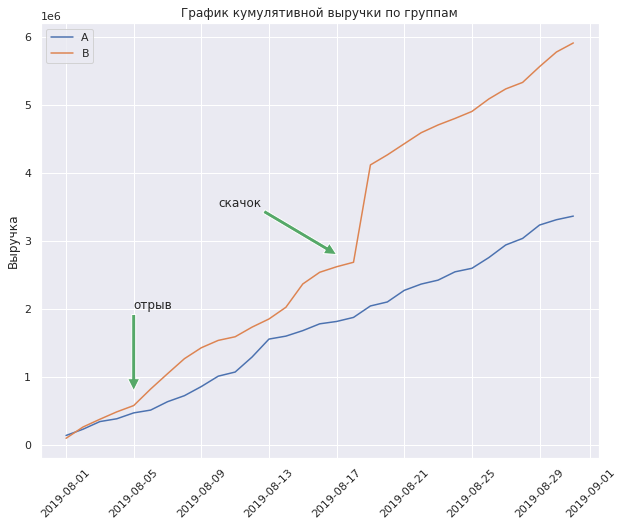

In [11]:
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.annotate('скачок', xy=('2019-08-17', 2800000), xytext=('2019-08-10', 3500000),
            arrowprops=dict(facecolor='g'))
plt.annotate('отрыв', xy=('2019-08-05', 800000), xytext=('2019-08-05', 2000000),
            arrowprops=dict(facecolor='g')) 
plt.title('График кумулятивной выручки по группам')
plt.ylabel("Выручка")
plt.xticks(rotation=45)
plt.legend()
plt.show()

Вывод: Сегмент В вырвался вперед и продолжает лидировать. Но в середине есть резкий скачок, что может указаывать на анмально большие заказы, которые влияют на результаты.

#### Построим график кумулятивного среднего чека по группам.

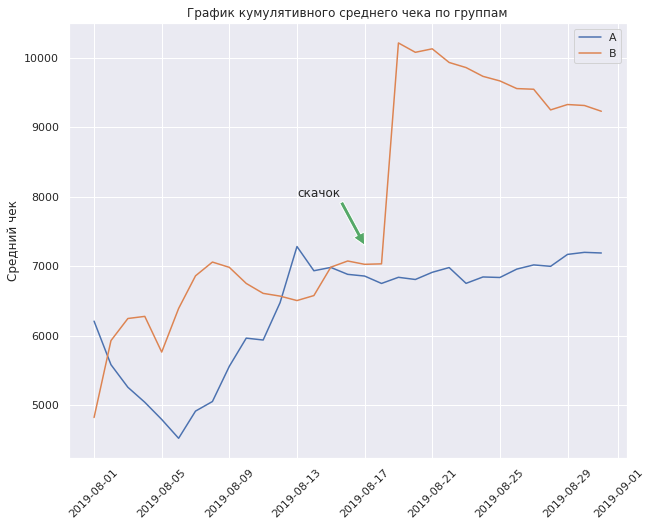

In [12]:
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.annotate('скачок', xy=('2019-08-17', 7300), xytext=('2019-08-13', 8000),
            arrowprops=dict(facecolor='g'))
plt.title('График кумулятивного среднего чека по группам')
plt.ylabel("Средний чек")
plt.xticks(rotation=45)
plt.legend()
plt.show()

Вывод: На этом графике видны сильные колебания, так же у сегмента В в середине резкий скачок. Принимать решение рано продолжим анализ

#### Построим график относительного изменения кумулятивного среднего чека группы B к группе A.

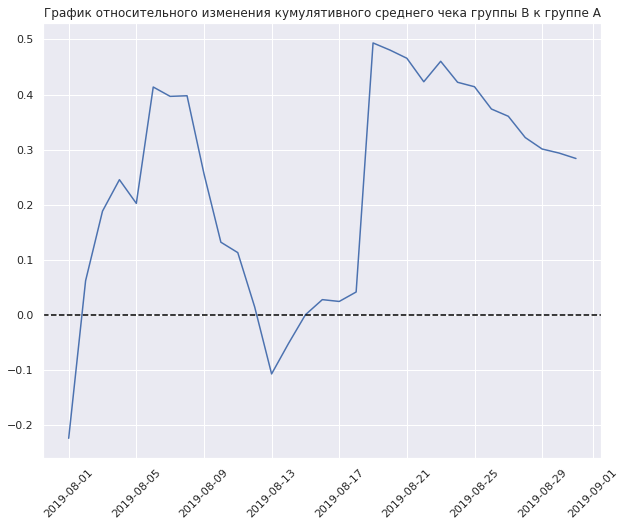

In [13]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], 
         (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--') 
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.xticks(rotation=45)
plt.show()

Вывод:Результаты теста значительно и резко менялись в несколько дат. Видимо именно тогда были совершены аномальные заказы.

#### Построим график кумулятивной конверсии по группам.

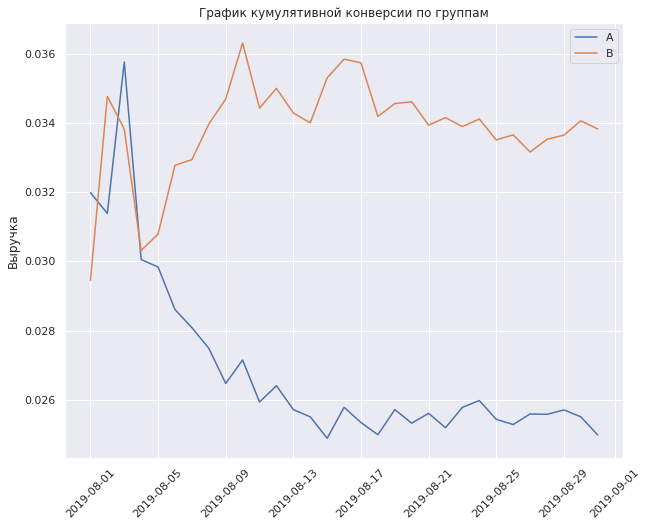

In [14]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.title('График кумулятивной конверсии по группам')
plt.ylabel("Выручка")
plt.xticks(rotation=45)
plt.legend()
plt.show()

Вывод: В начале теста сегмент А имел большую конверсию, но постепенно снизился и выровнялся. Сегмент В постепенно выровнялся и стал иметь большую конверсию. Сегмент В пока выглядит лучше. Продолжим анализ дальше.

#### Построим график относительного изменения кумулятивной конверсии группы B к группе A.

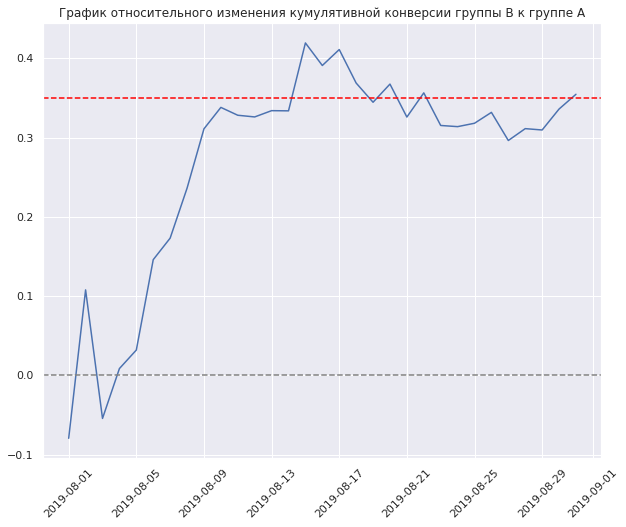

In [15]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], 
       left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.plot(mergedCumulativeConversions['date'], 
         mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, 
         label="Относительный прирост конверсии группы B относительно группы A")
plt.title('График относительного изменения кумулятивной конверсии группы B к группе A')
plt.axhline(y=0, color='grey', linestyle='--')
plt.axhline(y=0.35, color='red', linestyle='--')
plt.xticks(rotation=45)
plt.show()

Вывод: На графике видно, что группа В окончательно занимает лидирующую позицию по конверсии и зафиксировалась около прироста в 35% относительно группы А

#### Построим точечный график количества заказов по пользователям. 

In [16]:
# сделаем таблицу число заказов по пользователю
ordersByUsers = (
    orders.groupby('visitorid', as_index=False)
    .agg({'transactionid' : pd.Series.nunique})
)
ordersByUsers.columns = ['visitorid', 'orders']
print(ordersByUsers.sort_values(by='orders', ascending=False).head(10)) 

       visitorid  orders
591   2458001652       6
569   2378935119       5
917   3803269165       4
1023  4256040402       4
744   3062433592       4
897   3717692402       4
114    457167155       3
959   3967698036       3
667   2742574263       3
487   2038680547       3


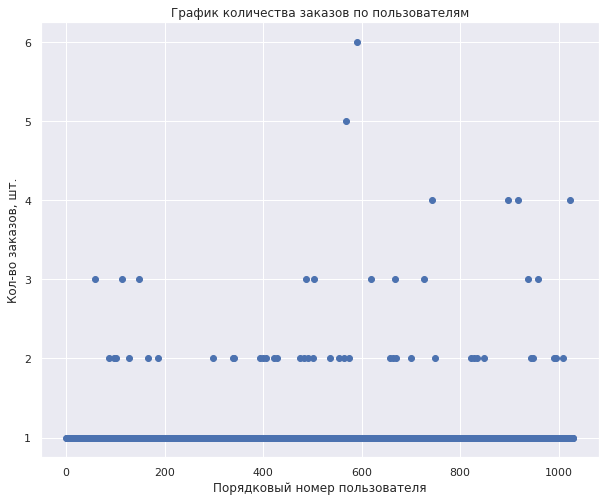

In [17]:
x_values = pd.Series(range(0, len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['orders']) 
plt.title('График количества заказов по пользователям')
plt.ylabel("Кол-во заказов, шт.")
plt.xlabel("Порядковый номер пользователя")
plt.show()

Вывод: Пользователей заказавшие более 3-х раз вполне могут быть аномальными. Продолжим анализировать.

#### Посчитаем 95-й и 99-й перцентили количества заказов на пользователя.

In [18]:
print('Перцентиль 95:',np.percentile(ordersByUsers['orders'], [95]))
print('Перцентиль 99:',np.percentile(ordersByUsers['orders'], [99]))

Перцентиль 95: [1.5]
Перцентиль 99: [3.]


Вывод: Не более 5% пользователей совершили больше 1 заказа и не более 1% пользователей больше 3 заказов. Считаю, все что выше 3 заказов аномально для периода в месяц

#### Построим точечный график стоимостей заказов.

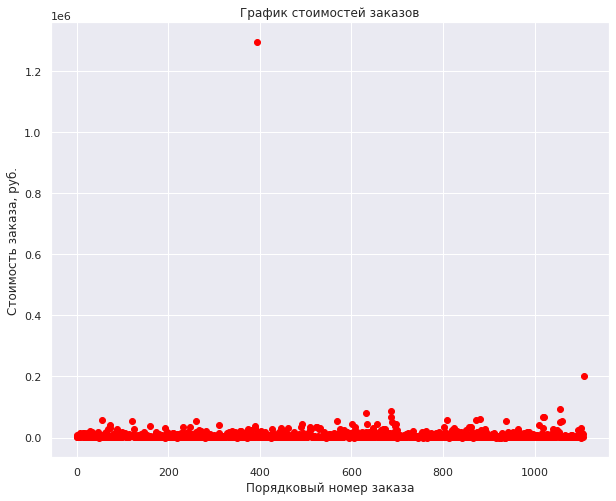

In [19]:
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'], color='red')
plt.title('График стоимостей заказов')
plt.ylabel("Стоимость заказа, руб.")
plt.xlabel("Порядковый номер заказа")
plt.show()

Вывод: Из графика видны два выброса в чуть более 200 000 руб. и в более чем 1 200 000 руб., последний скорее всего и вызвает скачки на графиках.

#### Посчитаем 95-й и 99-й перцентили стоимости заказов.

In [20]:
print('Перцентиль 95',np.percentile(orders['revenue'], [95]))
print('Перцентиль 99',np.percentile(orders['revenue'], [99]))

Перцентиль 95 [28033.75]
Перцентиль 99 [56457.78]


Вывод: Не более 5% пользователей совершили покупок на 28 033.75 и неболее 1% пользователей совершили покупок на 56 457.78. Считаю, все что выше суммы 56 457.78 аномально.

#### Посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным.

##### Подготовим данные

In [21]:

visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionid', 'visitorid', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionid': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionid', 'visitorid', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionid': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

display(data.head(5))

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,23,142779,21,101217,23,142779,21,101217,719,713,719,713
1,2019-08-02,19,91602,24,165531,42,234381,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,66,346854,61,380996,507,509,1845,1803
3,2019-08-04,11,41176,17,108571,77,388030,78,489567,717,770,2562,2573
4,2019-08-05,22,86383,23,92428,99,474413,101,581995,756,707,3318,3280


Названия столбцов полученных данных:
- date — дата;
- ordersPerDateA — количество заказов в выбранную дату в группе A;
- revenuePerDateA — суммарная выручка в выбранную дату в группе A;
- ordersPerDateB — количество заказов в выбранную дату в группе B;
- revenuePerDateB — суммарная выручка в выбранную дату в группе B;
- ordersCummulativeA — суммарное число заказов до выбранной даты включительно в группе A;
- revenueCummulativeA — суммарная выручка до выбранной даты включительно в группе A;
- ordersCummulativeB — суммарное количество заказов до выбранной даты включительно в группе B;
- revenueCummulativeB — суммарная выручка до выбранной даты включительно в группе B;
- visitorsPerDateA — количество пользователей в выбранную дату в группе A;
- visitorsPerDateB — количество пользователей в выбранную дату в группе B;
- visitorsCummulativeA — количество пользователей до выбранной даты включительно в группе A;
- visitorsCummulativeB — количество пользователей до выбранной даты включительно в группе B.

##### Создадим переменные ordersByUsersA и ordersByUsersB со столбцами ['visitorid, 'orders'], где для пользователей, совершивших хотя бы 1 заказ, будет указано число заказов.

In [22]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorid', as_index=False)
    .agg({'transactionid': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitorid', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorid', as_index=False)
    .agg({'transactionid': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitorid', 'orders']


##### Объявим переменные sampleA и sampleB, в которых пользователям с заказами будет соответствовать число заказов пользователя. А пользователям без заказов — нули

In [23]:
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)
sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

##### Применим тест Манна-Уитни.

Сформулируем гипотезы:
- H0: Конверсия в группе A равна конверсии в группе B
- H1: Конверсия в группе A НЕ равна конверсии в группе B

In [24]:
print( 'p-value',"{0:.5f}".format(st.mannwhitneyu(sampleA, sampleB)[1], alternative='two-sided'))     
print('относительное различие в конверсии',"{0:.3f}".format((data['ordersPerDateB'].sum()/data['visitorsPerDateB'].sum())/(data['ordersPerDateA'].sum()/data['visitorsPerDateA'].sum())-1))

p-value 0.00002
относительное различие в конверсии 0.355


Вывод: 
- p-value значительно меньше 0,05
- Значит, нулевую гипотезу отвергаем, статистически значимые различия есть.
- Относительный прирост коверсии группы В к группе А рвен 35,5%

#### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным.

Сформулируем гипотезы:
- H0: Средний чек группы A НЕ превосходит среднему чеку группы B
- H1: Средний чек группы A превосходит среднему чеку группы B

In [25]:
print('p-value','{0:.3f}'.format(st.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1], alternative='two-sided',))
print('относительный прирост среднего чека группы B:', '{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

p-value 0.765
относительный прирост среднего чека группы B: 0.284


Вывод:
- P-value значительно больше 0.05.
- Значит нулевую гипотезу не отвергаем, статстически значимых отличий в реднем чеке между группами, нет. 
- Средний чек группы B значительно выше среднего чека группы A на 28,4%

Приступим к анализу аномалий

#### Посчитаем статистическую значимость различий в конверсии между группами по «очищенным» данным.

Выше мы нашли границы аномалий:
Для 99-й перцентили стоимости заказа 56 457.78 рубля. 
Для 99-й перцентили числа заказов на одного пользователя 3.
Соответсвенно отсеем пользователей совершивших 3 заказа и более, или совершил заказ на сумму свыше 56 457.78

In [26]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 3]['visitorid'],
        ordersByUsersB[ordersByUsersB['orders'] > 3]['visitorid'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 56457.78]['visitorid']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))
print(abnormalUsers.shape)

1099     148427295
949      887908475
744      888512513
1103    1164614297
1136    1307669133
Name: visitorid, dtype: int64
(16,)


Всего 16 аномальных пользователей.

In [27]:
# Сначала подготовим выборки количества заказов по пользователям по группам теста
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitorid'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitorid'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

Применим статистический критерий Манна-Уитни к полученным выборкам:

Сформулируем гипотезы:
- H0: Конверсия в группе A равна конверсии в группе B
- H1: Конверсия в группе A НЕ равна конверсии в группе B

In [28]:
print('p-value','{0:.5f}'.format(st.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1], alternative='two-sided',))
print('относительное различие в конверсии','{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

p-value 0.00003
относительное различие в конверсии 0.301


Вывод: Результаты по конверсии практически не изменились, значит нулевую гипотезу снова отвергаем, конверсии групп не равны

#### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по "очищенным» данным". 

Сформулируем гипотезы:
- H0: Средний чек группы A НЕ превосходит среднему чеку группы B
- H1: Средний чек группы A превосходит среднему чеку группы B

In [29]:
print('p-value',
    '{0:.5f}'.format(
        st.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorid'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorid'].isin(abnormalUsers)),
                )
            ]['revenue'],
        alternative='two-sided')[1]
    )
)

print('относительный прирост среднего чека группы B:',
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorid'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorid'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

p-value 0.92438
относительный прирост среднего чека группы B: -0.021


Вывод: 
- P-value увеличился, но и разница между сегментами изменилась.
- Значит нулевую гипотезу не отвергаем, статстически значимых отличий в реднем чеке между группами, нет. 
- Средний чек группы B ниже среднего чека группы A на 2,1%

### Результаты теста

1. В первой части проекта мы провели приоритезацию 9-ти гипотез по увеличению выручки интернет-магазина. С помощью двух фреймворков ICE и RICE мы получили разные приоритеты. Все дело в параметре reach (скольких пользователей затронет изменение, которое мы хотим внести).В нашем случае охват важен и  наиболее  приоритетными гипотезами будут:
- "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок" на первом месте в приоритезации.
- "Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа" второе место.
2. Во второй части проекта мы провели анализ данных, проведенного А/В теста:
- В ходе предобработки данных, были выявлены пользователи вошедшие в обе группы теста и были удалены.
- График различия среднего чека говорит о том, что результаты группы B лучше, где то на 28%
- График различия конверсии между группами сообщает, что результаты группы B лучше группы A и нет значительной тенденции к ухудшению;
- При подсчете статистической значимости среднего чека с помощью теста Манна-Уитни по "сырым" и по "очищенным" данным различия групп A и B отстутствуют, несмотря на то, что средний чек группы B оказался незначительно на 2,1% ниже среднего чека группы A по "очищенным" данным, в то время как по "сырым" данным, он был больше на 35,5%, - и всё это из-за одного аномального заказа на 1,2 млн. 
- При подсчете статистической значимости в конверсии с помощью теста Манна-Уитни по "сырым" и по "очищенным" данным групп A и B показал,что статистически значимые различия есть.

Исходя из выше сказанного считаю, что можно принять решение остановить тестирование и признать его успешным: группа B значительно лучше группы A по конверсии, хотя по среднему чеку группы примерно равны.